In [1]:
import os
import re
import pandas as pd
import numpy as np

import urllib.request
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf


from konlpy.tag import Okt
from konlpy.tag import Mecab

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.initializers import Constant
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

from collections import Counter
import gensim
from gensim.models import KeyedVectors
from gensim.models.keyedvectors import Word2VecKeyedVectors

# 1. 데이터 준비

In [2]:
train_data = pd.read_table('~/aiffel/ratings_train.txt')
test_data = pd.read_table('~/aiffel/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


# 2. 데이터로더 구성

In [3]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 

In [4]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [5]:
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]


def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외


def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [6]:
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

# 3. 모델 구성을 위한 데이터 분석 및 가공

In [7]:
total_data_text = list(X_train) + list(X_test)

num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [8]:
max_tokens = np.mean(num_tokens) + 2.5 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

pad_sequences maxlen :  48
전체 문장의 0.9548784420929768%가 maxlen 설정값 이내에 포함됩니다. 


In [9]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='post',
                                                        maxlen=maxlen)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='post',
                                                       maxlen=maxlen)

print(X_train.shape)

(146182, 48)


# 4. 모델 구성 및 validation set 구성

In [10]:
x_val = X_train[:10000]   
y_val = y_train[:10000]

partial_x_train = X_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(136182, 48)
(136182,)


In [11]:
vocab_size = 10000 
word_vector_dim = 128

# RNN (LSTM)
LSTM = keras.Sequential()
LSTM.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
LSTM.add(keras.layers.LSTM(128))
LSTM.add(keras.layers.Dense(1, activation='sigmoid'))
LSTM.summary()



# GlobalMaxPooling1D
GMP = keras.Sequential()
GMP.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
GMP.add(keras.layers.GlobalMaxPooling1D())
GMP.add(keras.layers.Dense(8, activation='relu'))
GMP.add(keras.layers.Dense(1, activation='sigmoid'))
GMP.summary()

# # 1D CNN

cnn = keras.Sequential()
cnn.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,))) 
cnn.add(keras.layers.Conv1D(16, 7, activation='relu'))
cnn.add(keras.layers.MaxPooling1D(5))
cnn.add(keras.layers.Conv1D(16, 7, activation='relu'))
cnn.add(keras.layers.GlobalMaxPooling1D())
cnn.add(keras.layers.Dense(16, activation='relu'))
cnn.add(keras.layers.Dense(1, activation='sigmoid'))
cnn.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 128)         1280000   
_________________________________________________________________
lstm (LSTM)                  (None, 128)               131584    
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 1,411,713
Trainable params: 1,411,713
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 128)         1280000   
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
________________________

In [12]:
LSTM.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

cnn.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

GMP.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


# 5 모델 훈련 개시

In [13]:
early = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
check = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_bast_only=True)

In [14]:
# LSTM Training

LSTM_history = LSTM.fit(partial_x_train,
                    partial_y_train,
                    epochs=10,
                    callbacks=[early, check],
                    batch_size=32,
                    validation_data=(x_val, y_val),
                    verbose=1)


Epoch 1/10
4256/4256 [==============================] - 27s 6ms/step - loss: 0.3975 - accuracy: 0.8159 - val_loss: 0.3176 - val_accuracy: 0.8653

Epoch 00001: saving model to best_model.h5
Epoch 2/10
4256/4256 [==============================] - 23s 5ms/step - loss: 0.2916 - accuracy: 0.8782 - val_loss: 0.3217 - val_accuracy: 0.8676

Epoch 00002: saving model to best_model.h5
Epoch 3/10
4256/4256 [==============================] - 23s 5ms/step - loss: 0.2509 - accuracy: 0.8962 - val_loss: 0.3169 - val_accuracy: 0.8637

Epoch 00003: saving model to best_model.h5
Epoch 4/10
4256/4256 [==============================] - 23s 5ms/step - loss: 0.2175 - accuracy: 0.9113 - val_loss: 0.3400 - val_accuracy: 0.8580

Epoch 00004: saving model to best_model.h5
Epoch 5/10
4256/4256 [==============================] - 23s 5ms/step - loss: 0.1934 - accuracy: 0.9222 - val_loss: 0.3769 - val_accuracy: 0.8574

Epoch 00005: saving model to best_model.h5
Epoch 6/10
4256/4256 [==============================] -

In [15]:
# LSTM Evaluation
result_lstm = LSTM.evaluate(X_test,  y_test, verbose=2)

print(result_lstm)

1537/1537 - 3s - loss: 0.4738 - accuracy: 0.8558
[0.47376036643981934, 0.8558292984962463]


In [16]:
# cnn Training
cnn_history = cnn.fit(partial_x_train,
                    partial_y_train,
                    epochs=10,
                    callbacks=[early, check],
                    batch_size=32,
                    validation_data=(x_val, y_val),
                    verbose=1)


Epoch 1/10
4256/4256 [==============================] - 20s 4ms/step - loss: 0.3687 - accuracy: 0.8326 - val_loss: 0.3228 - val_accuracy: 0.8570

Epoch 00001: saving model to best_model.h5
Epoch 2/10
4256/4256 [==============================] - 18s 4ms/step - loss: 0.2694 - accuracy: 0.8887 - val_loss: 0.3334 - val_accuracy: 0.8582

Epoch 00002: saving model to best_model.h5
Epoch 3/10
4256/4256 [==============================] - 18s 4ms/step - loss: 0.1966 - accuracy: 0.9230 - val_loss: 0.3721 - val_accuracy: 0.8577

Epoch 00003: saving model to best_model.h5
Epoch 4/10
4256/4256 [==============================] - 18s 4ms/step - loss: 0.1357 - accuracy: 0.9486 - val_loss: 0.4333 - val_accuracy: 0.8429

Epoch 00004: saving model to best_model.h5
Epoch 5/10
4256/4256 [==============================] - 18s 4ms/step - loss: 0.0966 - accuracy: 0.9645 - val_loss: 0.5229 - val_accuracy: 0.8454

Epoch 00005: saving model to best_model.h5
Epoch 6/10
4256/4256 [==============================] -

In [17]:
# cnn Evaluation
result_cnn = cnn.evaluate(X_test, y_test, verbose=2)

print(result_cnn)

1537/1537 - 2s - loss: 0.6123 - accuracy: 0.8367
[0.6122896671295166, 0.8367475867271423]


In [18]:
# GMP Training
GMP_history = GMP.fit(partial_x_train,
                    partial_y_train,
                    epochs=10,
                    callbacks=[early, check],
                    batch_size=32,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
4256/4256 [==============================] - 13s 3ms/step - loss: 0.3795 - accuracy: 0.8295 - val_loss: 0.3356 - val_accuracy: 0.8512

Epoch 00001: saving model to best_model.h5
Epoch 2/10
4256/4256 [==============================] - 13s 3ms/step - loss: 0.2971 - accuracy: 0.8758 - val_loss: 0.3323 - val_accuracy: 0.8539

Epoch 00002: saving model to best_model.h5
Epoch 3/10
4256/4256 [==============================] - 13s 3ms/step - loss: 0.2518 - accuracy: 0.8983 - val_loss: 0.3392 - val_accuracy: 0.8545

Epoch 00003: saving model to best_model.h5
Epoch 4/10
4256/4256 [==============================] - 13s 3ms/step - loss: 0.2099 - accuracy: 0.9176 - val_loss: 0.3640 - val_accuracy: 0.8550

Epoch 00004: saving model to best_model.h5
Epoch 5/10
4256/4256 [==============================] - 13s 3ms/step - loss: 0.1711 - accuracy: 0.9341 - val_loss: 0.4087 - val_accuracy: 0.8489

Epoch 00005: saving model to best_model.h5
Epoch 6/10
4256/4256 [==============================] -

In [19]:
# GMP Evaluation
result_GMP = GMP.evaluate(X_test, y_test, verbose=2)

print(result_GMP)

1537/1537 - 2s - loss: 0.5284 - accuracy: 0.8358
[0.5284093618392944, 0.8358321189880371]


# 6. Loss, Accuracy 그래프 시각화

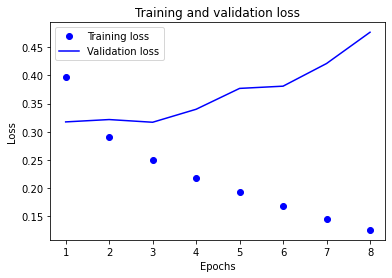

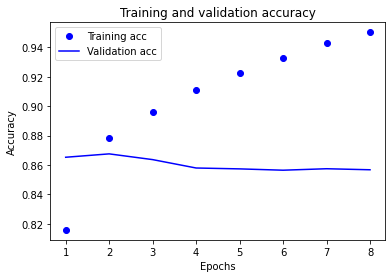

In [20]:
# LSTM
history_dict = LSTM_history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')

plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.clf()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

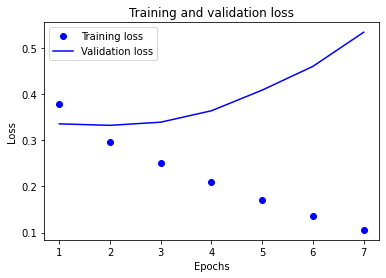

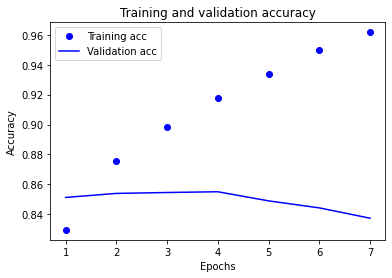

In [21]:
# GMP
history_dict = GMP_history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')

plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.clf()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

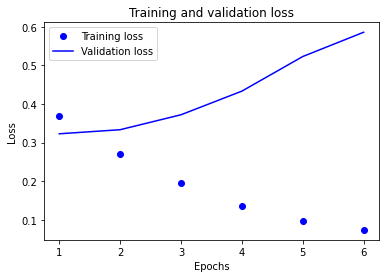

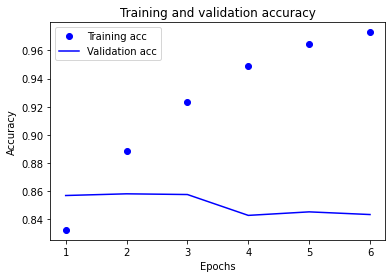

In [22]:
# cnn
history_dict = cnn_history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')

plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.clf()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# 7. 학습된 Embedding 레이어 분석

In [23]:
embedding_lstm = LSTM.layers[0]
lstm_weights = embedding_lstm.get_weights()[0]
print(lstm_weights.shape)

(10000, 128)


In [24]:
embedding_cnn = cnn.layers[0]
cnn_weights = embedding_cnn.get_weights()[0]
print(cnn_weights.shape)

(10000, 128)


In [25]:
embedding_GMP = GMP.layers[0]
GMP_weights = embedding_GMP.get_weights()[0]
print(GMP_weights.shape)

(10000, 128)


In [27]:
lstm_word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/LSTMword2vec.txt'
f = open(lstm_word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))

vectors = embedding_lstm.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [28]:
cnn_word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/cnnword2vec.txt'
f = open(cnn_word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))

vectors = embedding_cnn.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [29]:
GMP_word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/GMPword2vec.txt'
f = open(GMP_word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))

vectors = embedding_GMP.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [31]:
word_vectors_lstm = Word2VecKeyedVectors.load_word2vec_format(lstm_word2vec_file_path, binary=False)
vector = word_vectors_lstm['컴퓨터']
vector

array([ 0.07467971,  0.05443269,  0.05479737,  0.10580174,  0.20510367,
        0.07844499, -0.20592763,  0.05207902, -0.01522373,  0.13294859,
        0.2877522 ,  0.24611762, -0.13879469,  0.07127807,  0.04499198,
       -0.0997642 , -0.03299456, -0.07335308,  0.11866134, -0.04940414,
       -0.27603722,  0.02533613,  0.16565278,  0.2165266 ,  0.14757222,
       -0.16616407,  0.20478132,  0.01657029,  0.07710789, -0.03975914,
        0.1362146 , -0.06534535,  0.04099166, -0.03270842, -0.02526894,
        0.19407283,  0.14033604, -0.15394032, -0.14787567, -0.13734356,
        0.2132823 ,  0.13862656, -0.26805368,  0.15932824, -0.00285255,
       -0.13873613,  0.07724152,  0.15462498,  0.25600195,  0.18957137,
       -0.16230816,  0.18554357, -0.05476798, -0.15774119,  0.20483138,
        0.04301646,  0.00311638, -0.08133323,  0.06399409,  0.07733989,
       -0.02754118,  0.00828974, -0.09348907,  0.02241368,  0.05055557,
        0.20006402, -0.11030862,  0.14121589, -0.24854128,  0.01

In [32]:
word_vectors_lstm.similar_by_word("감동")

[('따뜻', 0.860535204410553),
 ('끌리', 0.8285865187644958),
 ('히틀러', 0.8278337121009827),
 ('돌아보', 0.8253747820854187),
 ('슬픔', 0.8251001238822937),
 ('통쾌', 0.8246668577194214),
 ('친근', 0.8217938542366028),
 ('거북이', 0.8214278817176819),
 ('리암니슨', 0.8207499384880066),
 ('탄탄', 0.8194423317909241)]

# 8. 한국어 Word2Vec 임베딩 활용 -> 성능 개선

In [33]:
word2vec_file_path2 = os.getenv('HOME')+'/data/word2vec_ko.model'
word_vectors = Word2VecKeyedVectors.load(word2vec_file_path2)
pre_word2vec = gensim.models.Word2Vec.load(word2vec_file_path2)


vector = word_vectors.wv['끝']
vector

array([ 1.038851  , -1.1634965 ,  2.2386286 ,  0.8971453 , -2.088168  ,
       -4.1942534 , -0.02519768, -0.69813883, -0.2908033 , -1.4651134 ,
       -2.6863668 ,  0.7999443 , -0.6957915 , -0.5018775 ,  3.5025773 ,
        0.21326113, -0.6588098 , -1.1900496 ,  0.61399573,  2.1247969 ,
        0.1549463 ,  3.0840218 ,  3.1680267 , -3.9143991 ,  3.6073153 ,
        0.5315545 , -0.3511633 , -1.107248  ,  1.7767181 , -0.95981866,
        2.6072454 , -0.00697957, -3.27628   ,  1.558644  ,  0.81922376,
        1.9231955 ,  3.7026553 , -0.53824735, -0.4920138 ,  2.4657123 ,
       -2.620749  , -0.08950733,  0.61453176,  1.8866426 ,  0.257866  ,
       -2.7827141 ,  2.9129577 , -0.6313133 ,  2.0387425 , -4.222685  ,
       -2.7560544 ,  1.7903243 , -1.3080189 , -2.5531402 , -0.43849912,
       -3.1073573 , -0.29090825,  5.1817617 ,  1.9604833 , -5.1421604 ,
       -0.71431434,  4.5624633 , -0.55525815, -3.3019137 ,  1.6761336 ,
       -1.9606539 , -0.2726863 ,  0.2465995 ,  1.2685091 ,  1.60

In [34]:
vocab_size = 10000 
word_vector_dim = 100  
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

for i in range(4,vocab_size):
    if index_to_word[i] in pre_word2vec.wv.key_to_index:
        embedding_matrix[i] = pre_word2vec.wv.vectors[pre_word2vec.wv.key_to_index[index_to_word[i]]]

In [35]:
#lstm
vocab_size = 10000
word_vector_dim = 100

LSTM = keras.Sequential()
LSTM.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),
                                 input_length=maxlen, 
                                 trainable=True))
LSTM.add(keras.layers.LSTM(64))
LSTM.add(keras.layers.Dense(256, activation='relu'))
LSTM.add(keras.layers.Dense(1, activation='sigmoid'))


# CNN
cnn = keras.Sequential()
cnn.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,))) 
cnn.add(keras.layers.Conv1D(16, 7, activation='relu'))
cnn.add(keras.layers.MaxPooling1D(5))
cnn.add(keras.layers.Conv1D(16, 7, activation='relu'))
cnn.add(keras.layers.GlobalMaxPooling1D())
cnn.add(keras.layers.Dense(16, activation='relu'))
cnn.add(keras.layers.Dense(1, activation='sigmoid'))


# GMP
GMP = keras.Sequential()
GMP.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),
                                 input_length=maxlen, 
                                 trainable=True))
GMP.add(keras.layers.GlobalMaxPooling1D())
GMP.add(keras.layers.Dense(8, activation='relu'))
GMP.add(keras.layers.Dense(1, activation='sigmoid'))

In [40]:
LSTM.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 48, 100)           1000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                42240     
_________________________________________________________________
dense_5 (Dense)              (None, 256)               16640     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 257       
Total params: 1,059,137
Trainable params: 1,059,137
Non-trainable params: 0
_________________________________________________________________


In [41]:
LSTM.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])



In [42]:
ealry_ko = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
check_ko = ModelCheckpoint('best_model_ko.h5', monitor='val_acc', mode='max', verbose=1, save_bast_only=True)

In [44]:
history_LSTM2 = LSTM.fit(partial_x_train,
                    partial_y_train,
                    epochs=10,
                    callbacks=[ealry_ko, check_ko],
                    batch_size=32,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
4256/4256 [==============================] - 23s 5ms/step - loss: 0.4711 - accuracy: 0.7506 - val_loss: 0.3506 - val_accuracy: 0.8451

Epoch 00001: saving model to best_model_ko.h5
Epoch 2/10
4256/4256 [==============================] - 21s 5ms/step - loss: 0.3236 - accuracy: 0.8610 - val_loss: 0.3340 - val_accuracy: 0.8502

Epoch 00002: saving model to best_model_ko.h5
Epoch 3/10
4256/4256 [==============================] - 21s 5ms/step - loss: 0.2855 - accuracy: 0.8799 - val_loss: 0.3229 - val_accuracy: 0.8604

Epoch 00003: saving model to best_model_ko.h5
Epoch 4/10
4256/4256 [==============================] - 21s 5ms/step - loss: 0.2590 - accuracy: 0.8923 - val_loss: 0.3185 - val_accuracy: 0.8627

Epoch 00004: saving model to best_model_ko.h5
Epoch 5/10
4256/4256 [==============================] - 21s 5ms/step - loss: 0.2341 - accuracy: 0.9042 - val_loss: 0.3248 - val_accuracy: 0.8621

Epoch 00005: saving model to best_model_ko.h5
Epoch 6/10
4256/4256 [==================

In [45]:
result_lstm2 = LSTM.evaluate(X_test,  y_test, verbose=2)

print(result_lstm2)

1537/1537 - 3s - loss: 0.4091 - accuracy: 0.8533
[0.4090568423271179, 0.8532660603523254]


In [46]:
# cnn 

In [47]:
cnn.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [48]:

history_cnn = cnn.fit(partial_x_train,
                    partial_y_train,
                    epochs=10,
                    callbacks=[ealry_ko, check_ko],
                    batch_size=32,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
4256/4256 [==============================] - 18s 4ms/step - loss: 0.3694 - accuracy: 0.8332 - val_loss: 0.3239 - val_accuracy: 0.8574

Epoch 00001: saving model to best_model_ko.h5
Epoch 2/10
4256/4256 [==============================] - 18s 4ms/step - loss: 0.2721 - accuracy: 0.8873 - val_loss: 0.3249 - val_accuracy: 0.8596

Epoch 00002: saving model to best_model_ko.h5
Epoch 3/10
4256/4256 [==============================] - 18s 4ms/step - loss: 0.1993 - accuracy: 0.9209 - val_loss: 0.3506 - val_accuracy: 0.8547

Epoch 00003: saving model to best_model_ko.h5
Epoch 4/10
4256/4256 [==============================] - 18s 4ms/step - loss: 0.1376 - accuracy: 0.9474 - val_loss: 0.4428 - val_accuracy: 0.8464

Epoch 00004: saving model to best_model_ko.h5
Epoch 5/10
4256/4256 [==============================] - 18s 4ms/step - loss: 0.0991 - accuracy: 0.9630 - val_loss: 0.5078 - val_accuracy: 0.8443

Epoch 00005: saving model to best_model_ko.h5
Epoch 6/10
4256/4256 [==================

In [49]:
results_cnn = cnn.evaluate(X_test, y_test, verbose=2)

print(results_cnn)

1537/1537 - 2s - loss: 0.6190 - accuracy: 0.8413
[0.6189604997634888, 0.8413247466087341]


In [50]:
# GMP

In [52]:
GMP.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [53]:
GMP_history = GMP.fit(partial_x_train,
                    partial_y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
4256/4256 [==============================] - 14s 3ms/step - loss: 0.6190 - accuracy: 0.6557 - val_loss: 0.5418 - val_accuracy: 0.7263
Epoch 2/10
4256/4256 [==============================] - 13s 3ms/step - loss: 0.5014 - accuracy: 0.7533 - val_loss: 0.4784 - val_accuracy: 0.7702
Epoch 3/10
4256/4256 [==============================] - 13s 3ms/step - loss: 0.4513 - accuracy: 0.7873 - val_loss: 0.4486 - val_accuracy: 0.7917
Epoch 4/10
4256/4256 [==============================] - 13s 3ms/step - loss: 0.4209 - accuracy: 0.8065 - val_loss: 0.4312 - val_accuracy: 0.7990
Epoch 5/10
4256/4256 [==============================] - 13s 3ms/step - loss: 0.3972 - accuracy: 0.8204 - val_loss: 0.4420 - val_accuracy: 0.7979
Epoch 6/10
4256/4256 [==============================] - 13s 3ms/step - loss: 0.3792 - accuracy: 0.8310 - val_loss: 0.4089 - val_accuracy: 0.8154
Epoch 7/10
4256/4256 [==============================] - 13s 3ms/step - loss: 0.3638 - accuracy: 0.8401 - val_loss: 0.4025 - val_ac

In [54]:
results = GMP.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.3999 - accuracy: 0.8220
[0.39989766478538513, 0.8219988942146301]
